<a href="https://colab.research.google.com/github/ViktoriaZaremba/cv/blob/master/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
import pandas as pd


**Model**

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
class VGG16( Model ):
  def __init__( self, num_classes, model_configuration ):
    
    if model_configuration == 'D':
      filter_conf = (3, 3)
    elif model_configuration == 'C':
      filter_conf = (1, 1)
    
    super( VGG16, self ).__init__( )
    self.conv1     = Conv2D( 64, kernel_size = (3, 3), padding = 'same', activation = 'relu' )
    self.conv2     = Conv2D( 64, kernel_size = (3, 3), padding = 'same', activation = 'relu' )
    self.max_pool1 = MaxPooling2D( pool_size=( 2, 2 ), strides = (2, 2) )

    self.conv3     = Conv2D( 128, kernel_size = (3, 3), padding = 'same', activation = 'relu' )
    self.conv4     = Conv2D( 128, kernel_size = (3, 3), padding = 'same', activation = 'relu' )
    self.max_pool2 = MaxPooling2D( pool_size=( 2, 2 ), strides = (2, 2) )
    
    self.conv5     = Conv2D( 256, kernel_size = (3, 3), padding = 'same', activation = 'relu' )
    self.conv6     = Conv2D( 256, kernel_size = (3, 3), padding = 'same', activation = 'relu' )
    self.conv7     = Conv2D( 256, kernel_size = filter_conf, padding = 'same', activation = 'relu' )  # <-- difference between configurations
    self.max_pool3 = MaxPooling2D( pool_size=( 2, 2 ), strides = (2, 2) )
    
    self.conv8     = Conv2D( 512, kernel_size = (3, 3), padding = 'same', activation = 'relu' )
    self.conv9     = Conv2D( 512, kernel_size = (3, 3), padding = 'same', activation = 'relu' )
    self.conv10    = Conv2D( 512, kernel_size = filter_conf, padding = 'same', activation = 'relu' )  # <-- difference between configurations
    self.max_pool4 = MaxPooling2D( pool_size=( 2, 2 ), strides = (2, 2) )
    
    self.flatten   = Flatten(  ) 
    self.dense1    = Dense( 4096, activation = 'relu' ) 
    self.dropout1  = Dropout( 0.2 )
    self.dense2    = Dense( 4096, activation = 'relu' ) 
    self.dropout2  = Dropout( 0.2 )
    self.dense3    = Dense( num_classes, activation = 'softmax' ) 
    
  def call( self, x ):
    x = self.max_pool1( self.conv2( self.conv1( x ) ) )
    x = self.max_pool2( self.conv4( self.conv3( x ) ) )
    x = self.max_pool3( self.conv7( self.conv6( self.conv5( x ) ) ) )
    x = self.max_pool4( self.conv10( self.conv9( self.conv8( x ) ) ) ) 
    x = self.flatten( x )
    x = self.dense3( self.dropout2 ( self.dense2( self.dropout1( self.dense1( x ) ) ) ) )
    return x

**Data preprocesing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fashion-mnist_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fashion-mnist_train.csv")

In [ ]:
# get data and transform to numpy
y_test = (test.iloc[:,0]).to_numpy()
X_test = (test.iloc[:,1:]).to_numpy()
y_train = (train.iloc[:,0]).to_numpy()
X_train = (train.iloc[:,1:]).to_numpy()

In [ ]:
num_classes = 10
img_width = 28
img_heigh = 28
img_ch = 1
input_shape = (img_width, img_heigh, img_ch)

# normalize data
X_train, X_test = X_train / 255, X_test / 255

# reshape input 
X_train = X_train.reshape(X_train.shape[0], *input_shape)
X_test = X_test.reshape(X_test.shape[0], *input_shape)

# one-hot
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
print('Train shape: {}, {}'.format(X_train.shape,y_train.shape))
print('Test shape: {}, {}'.format(X_test.shape,y_test.shape))

Train shape: (60000, 28, 28, 1), (60000, 10)
Test shape: (60000, 28, 28, 1), (60000, 10)


**compile model**

In [ ]:
model_C = VGG16(num_classes, "C")
model_C.compile(  tf.keras.optimizers.Adam(learning_rate=1e-4), loss = 'categorical_crossentropy',
                metrics = 'accuracy' )

# create callbacks
callbacks = [ 
  tf.keras.callbacks.ModelCheckpoint('best_model', monitor='val_accuracy', verbose=1, save_best_only=True),
  tf.keras.callbacks.ReduceLROnPlateau( factor = 0.1, patience = 3, min_lr = 0.00001, verbose = 1 )
 ]

history_C = model_C.fit(X_train, y_train, epochs = 25, batch_size = 256,
                    callbacks = callbacks, verbose = 1,
                    validation_data = (X_test,y_test) )

Epoch 1/25
234/235 [============================>.] - ETA: 0s - loss: 0.9105 - accuracy: 0.6484
Epoch 1: val_accuracy improved from -inf to 0.77948, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
235/235 [==============================] - 24s 97ms/step - loss: 0.9096 - accuracy: 0.6488 - val_loss: 0.5706 - val_accuracy: 0.7795 - lr: 1.0000e-04
Epoch 2/25
234/235 [============================>.] - ETA: 0s - loss: 0.4649 - accuracy: 0.8275
Epoch 2: val_accuracy improved from 0.77948 to 0.85150, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
235/235 [==============================] - 23s 97ms/step - loss: 0.4649 - accuracy: 0.8275 - val_loss: 0.4028 - val_accuracy: 0.8515 - lr: 1.0000e-04
Epoch 3/25
234/235 [============================>.] - ETA: 0s - loss: 0.3594 - accuracy: 0.8693
Epoch 3: val_accuracy improved from 0.85150 to 0.87978, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
235/235

In [ ]:
model_D = VGG16(num_classes, "D")
model_D.compile(  tf.keras.optimizers.Adam(learning_rate=1e-4), loss = 'categorical_crossentropy',
                metrics = 'accuracy' )

# create callbacks
callbacks = [ 
  tf.keras.callbacks.ModelCheckpoint('best_model', monitor='val_accuracy', verbose=1, save_best_only=True),
  tf.keras.callbacks.ReduceLROnPlateau( factor = 0.1, patience = 3, min_lr = 0.00001, verbose = 1 )
 ]

history_D = model_D.fit(X_train, y_train, epochs = 25, batch_size = 256,
                    callbacks = callbacks, verbose = 1,
                    validation_data = (X_test,y_test) )

Epoch 1/25
234/235 [============================>.] - ETA: 0s - loss: 0.8967 - accuracy: 0.6504
Epoch 1: val_accuracy improved from -inf to 0.78225, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
235/235 [==============================] - 28s 115ms/step - loss: 0.8960 - accuracy: 0.6506 - val_loss: 0.5571 - val_accuracy: 0.7822 - lr: 1.0000e-04
Epoch 2/25
234/235 [============================>.] - ETA: 0s - loss: 0.4811 - accuracy: 0.8164
Epoch 2: val_accuracy improved from 0.78225 to 0.84418, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
235/235 [==============================] - 26s 112ms/step - loss: 0.4807 - accuracy: 0.8166 - val_loss: 0.4261 - val_accuracy: 0.8442 - lr: 1.0000e-04
Epoch 3/25
234/235 [============================>.] - ETA: 0s - loss: 0.3700 - accuracy: 0.8628
Epoch 3: val_accuracy improved from 0.84418 to 0.87478, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
235/2

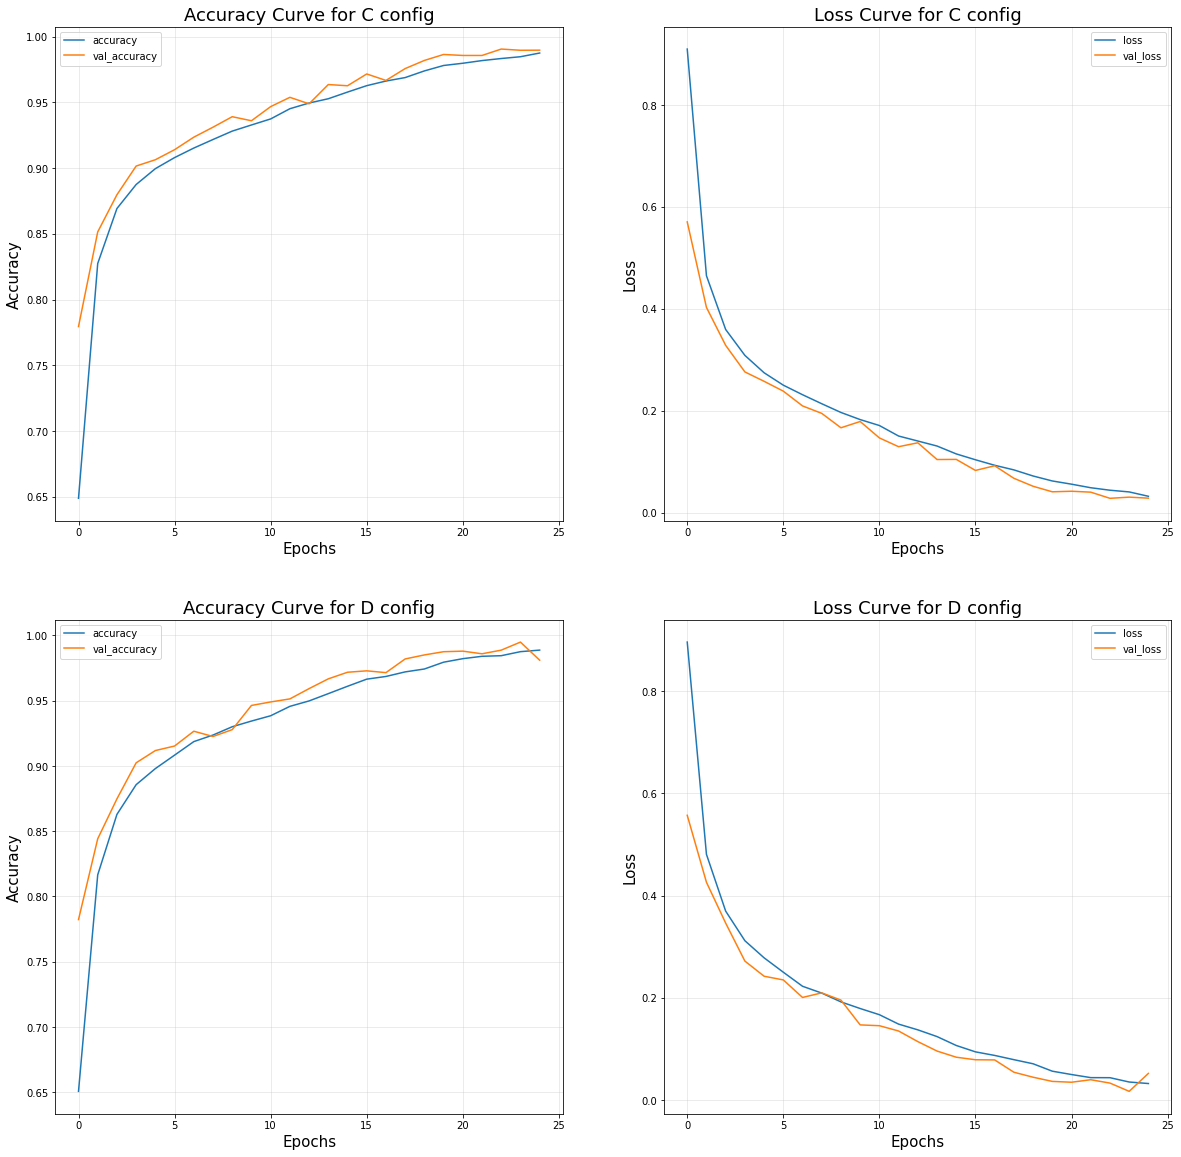

In [ ]:
# Diffining Figure
f = plt.figure(figsize=(20,20))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(221)

plt.plot(history_C.epoch,history_C.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history_C.epoch,history_C.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve for C config",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(222)

plt.plot(history_C.epoch,history_C.history['loss'],label="loss") # Loss curve for training set
plt.plot(history_C.epoch,history_C.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve for C config",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Accuracy)
f.add_subplot(223)

plt.plot(history_D.epoch,history_D.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history_D.epoch,history_D.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve for D config",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(224)

plt.plot(history_D.epoch,history_D.history['loss'],label="loss") # Loss curve for training set
plt.plot(history_D.epoch,history_D.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve for D config",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [ ]:
scores_C = model_C.evaluate(X_test, y_test)

1875/1875 [==============================] - 14s 7ms/step - loss: 0.0285 - accuracy: 0.9898


In [ ]:
scores_D = model_D.evaluate(X_test, y_test)

1875/1875 [==============================] - 16s 8ms/step - loss: 0.0521 - accuracy: 0.9811
